In [41]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.neighbors import KernelDensity
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [40]:
SYMBOLS = [
    'ABMD', 'ABNB', 'AMZN', 'ANET', 'APPH', 'ATVI', 'AXON', 'AYX', 
    'BILI', 'BYND', 'COUR','CPNG', 'DDOG', 'DOCU', 'DUOL', 'EDIT', 
    'ETSY', 'FSLY', 'FUV', 'GH', 'GMED', 'INTG', 'ISRG', 'JD', 
    'LULU', 'LUV', 'MDB', 'MELI', 'MNST', 'MTCH', 'NVCR', 'OKTA', 
    'PANW', 'PINS', 'PTON', 'QDEL', 'RDFN', 'RGEN', 'ROKU', 'SE', 
    'SHOP', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO', 'TWTR', 
    'UPST', 'VEEV', 'ZEN', 'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

53

In [247]:
TODAY = datetime.now().date()
START = TODAY - timedelta(2*365)
START, TODAY

(datetime.date(2019, 8, 22), datetime.date(2021, 8, 21))

In [248]:
batch = SYMBOLS + INDICES

In [249]:
data = yf.download(batch, start=START, end=TODAY).rename(columns={'Adj Close': 'AdjClose'})

[*********************100%***********************]  56 of 56 completed


In [250]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [256]:
LMB = 0.9

In [278]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    n = stock_data.shape[0]
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = (
        (stock_data.Close + stock_data.High + stock_data.Low + stock_data.Open) / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.Close / stock_data.est
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.sort_index(inplace=True)
    stock_data.head()
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
    return stock_data.resid.tolist()[-1], stock_data.dev.tolist()[-1]

(0.9108892914584175, 0.16666666666666666)

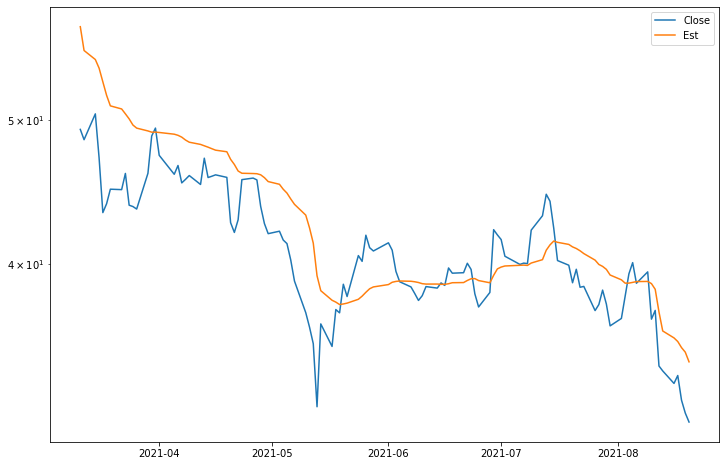

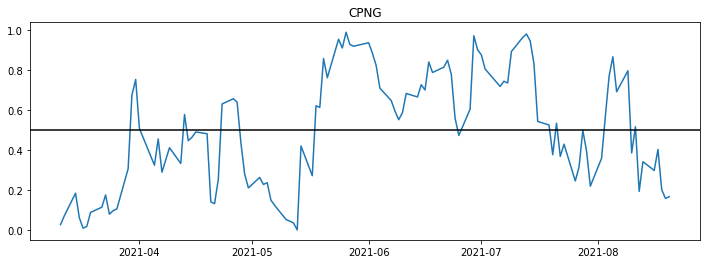

In [279]:
process_stock('CPNG', data.copy(), plot=True)

In [280]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    mult, dev = process_stock(stock, data)
    out.append([stock, mult, dev])

ABMD... ABNB... AMZN... ANET... APPH... ATVI... AXON... AYX... BILI... BYND... COUR... CPNG... DDOG... DOCU... DUOL... EDIT... ETSY... FSLY... FUV... GH... GMED... INTG... ISRG... JD... LULU... LUV... MDB... MELI... MNST... MTCH... NVCR... OKTA... PANW... PINS... PTON... QDEL... RDFN... RGEN... ROKU... SE... SHOP... TDOC... TEAM... TREX... TTD... TTWO... TWLO... TWTR... UPST... VEEV... ZEN... ZG... ZNGA... ^GSPC... ^IXIC... ^NYA... 

In [281]:
out = pd.DataFrame(data=out, columns=['stock', 'fair_value_mult', 'dev_quantile'])
out.to_csv('../data/dev_quantiles.csv', index=False)
out.sort_values('dev_quantile')

,stock,fair_value_mult,dev_quantile
18,FUV,0.754878,0.019841
30,NVCR,0.865562,0.023810
8,BILI,0.859531,0.029762
23,JD,0.943658,0.043651
14,DUOL,0.925403,0.055556
4,APPH,0.824505,0.056478
2,AMZN,0.957250,0.059524
50,ZEN,0.928126,0.069444
29,MTCH,0.933673,0.079365
33,PINS,0.901451,0.085317


In [282]:
!open ../data/dev_quantiles.csv